In [1]:
import json
import pandas as pd
from collections import defaultdict, Counter
import matplotlib.pyplot as plt

In [2]:
# Opening JSON file
filenames = ['syntax_gym_all_info_base16_400_pos_tagged.csv', 'close_word_sentences_all_info_base16_80_pos_tagged.csv', 'same_word_sentences_all_info_base16_80_pos_tagged.csv']
f = open(filenames[1])
 
# returns JSON object as 
# a dictionary
data = json.load(f)
 
# Closing file
f.close()


# Preprocessing

In [3]:
def string_to_tuple(string):
    # Remove parentheses and split by comma and strip quotes
    parts = string.strip("()").split(", ")
    word = parts[0].strip("''")
    index = int(parts[1])
    pos_tag = parts[2].strip("''")
    return word, index, pos_tag

def preprocess(data):
    int_data = {}
    for key, val in data.items():
        new_routes = {}
        int_key = int(key)
        for key2, val2 in val.items():
            new_key = string_to_tuple(key2)
            new_routes[new_key] = val2
        int_data[int_key] = new_routes
    return int_data

In [4]:
int_data = preprocess(data)

# Overall Layer Specs

In [5]:
pos_tag_routes = {}
pos_tag_names = defaultdict(list)

for key, val in int_data.items():
    for inner_key, inner_val in val.items():
        token_name, pos_tag = inner_key[0], inner_key[2]
        if pos_tag not in pos_tag_routes:
            pos_tag_routes[pos_tag] = [[] for _ in range(6)]
        pos_tag_names[pos_tag].append(token_name)
        for i, (step, route) in enumerate(inner_val):
            pos_tag_routes[pos_tag][i].append(route)

In [6]:
pos_tag_counts = defaultdict(list)
for key, val in pos_tag_routes.items():
    for i, array in enumerate(val):
        pos_tag_counts[key].append(Counter(array))
#         print(f"Counts for {key} in layer {i*2 + 1}:")
#         print(Counter(array))
#         print(" ")

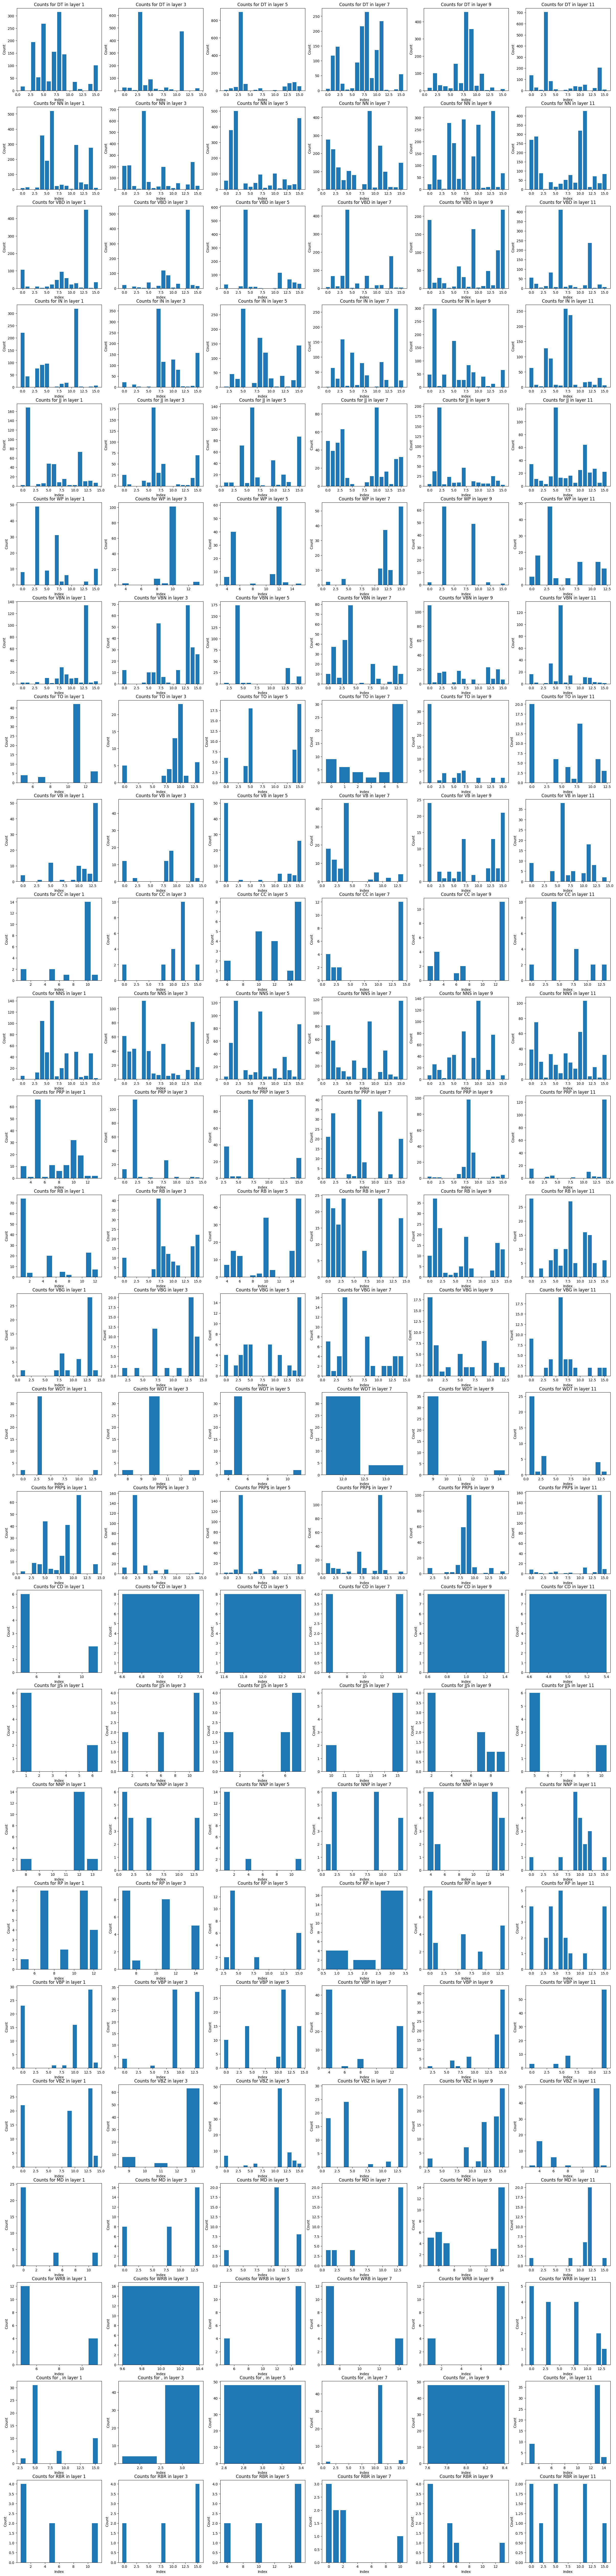

In [7]:
# Determine the layout of the subplot grid
num_pos_tags = len(pos_tag_counts)
num_layers = max(len(layers) for layers in pos_tag_counts.values())

# Set up the matplotlib figure and axes, based on the number of layers
fig, axes = plt.subplots(num_pos_tags, num_layers, figsize=(20, 10))
if num_pos_tags == 1:
    axes = np.array([axes])
elif num_layers == 1:
    axes = np.array([axes]).T

# Plot each Counter object
for i, (pos_tag, layers) in enumerate(pos_tag_counts.items()):
    for j, layer in enumerate(layers):
        # Sort the keys for consistent plotting
        keys = sorted(layer.keys())
        counts = [layer[key] for key in keys]
        ax = axes[i, j] if num_pos_tags > 1 else axes[j]
        ax.bar(keys, counts)
        ax.set_xticks(keys)
        ax.set_xticklabels(keys)
        ax.set_xlabel('Index')
        ax.set_ylabel('Count')
        ax.set_title(f'Counts for {pos_tag} in layer {j*2 + 1}')
        ax.legend([f'Index {k}' for k in keys])

# Adjust the layout
# plt.tight_layout()
plt.show()


# Distribution of experts per index

In [10]:
expert_per_index = defaultdict(lambda: [[] for _ in range(6)])

for key, val in int_data.items():
    for inner_key, inner_val in val.items():
        token_name, token_index, pos_tag = inner_key    
        for i, (step, route) in enumerate(inner_val):
            expert_per_index[token_index][i].append(route)


In [12]:
expert_per_index_counts = defaultdict(list)
for key, val in expert_per_index.items():
    for routes in val:
        expert_per_index_counts[key].append(Counter(routes))

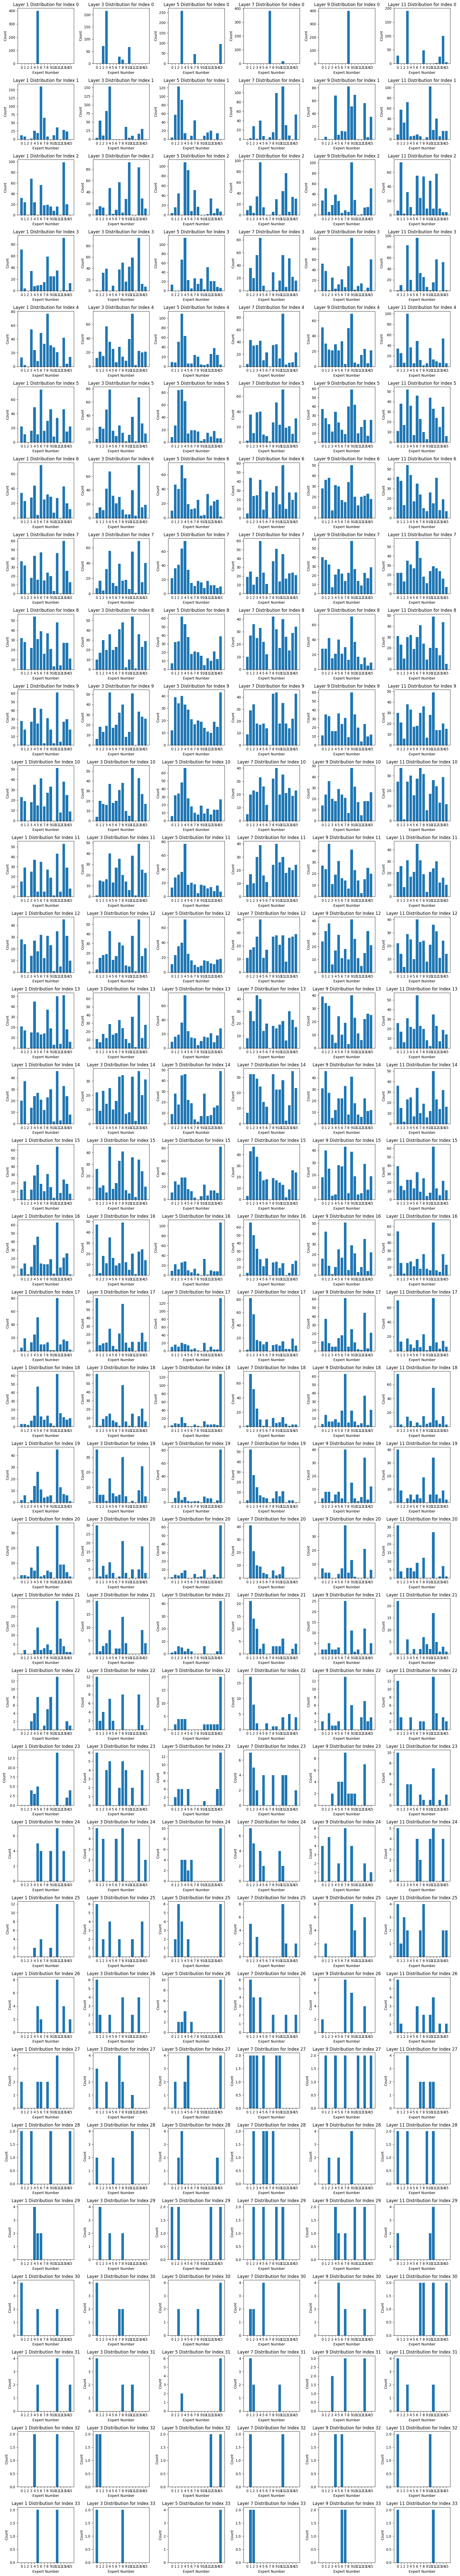

In [13]:
# Assuming expert_per_index_counts is defined
# Structure for expert_per_index_counts should be as per your data

num_indices = len(expert_per_index_counts)  # Number of indices
num_layers = 6  # Number of layers
num_experts = 16  # Total possible experts

# Create a subplot grid with one row per index and one column per layer
fig, axes = plt.subplots(num_indices, num_layers, figsize=(num_layers * 3, num_indices * 3), squeeze=False)

# Iterate over each index and its corresponding list of Counter objects
for index, layers in expert_per_index_counts.items():
    for layer_num, layer_counts in enumerate(layers):
        ax = axes[index][layer_num]

        # Ensure all experts are represented, even if their count is 0
        # Create a complete list of expert numbers from 0 to 7
        all_expert_numbers = list(range(num_experts))

        # Use .get method of Counter to fill in counts, defaulting to 0 if not found
        counts = [layer_counts.get(expert_number, 0) for expert_number in all_expert_numbers]

        # Plot with all experts represented
        ax.bar(all_expert_numbers, counts, width=0.8)  # Standardize bar width
        ax.set_xticks(all_expert_numbers)  # Set x-ticks to show all experts
        ax.set_xticklabels(all_expert_numbers)  # Label x-ticks with expert numbers
        ax.set_title(f'Layer {layer_num*2 + 1} Distribution for Index {index}')
        ax.set_xlabel('Expert Number')
        ax.set_ylabel('Count')

plt.tight_layout()
plt.show()
